[*********************100%***********************]  1 of 1 completed


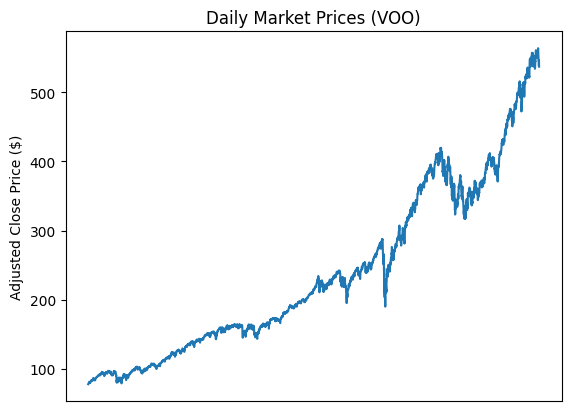

In [6]:
from lbm.datasets.voo import ClosePricesPreprocessor
from matplotlib import pyplot as plt

processor1 = ClosePricesPreprocessor(lookback=1)
train_loader, val_loader, test_loader = processor1.get_loaders()

prices = processor1.dataset.x
plt.plot(prices)
plt.title("Daily Market Prices (VOO)")
# turn off labels on x-axis
plt.ylabel("Adjusted Close Price ($)")
plt.xticks([])
plt.show()

In [22]:
import numpy as np
import torch

def test(model, dataloader, loss_fn, device='cpu'):
    model.to(device)
    model.eval()
    total_loss = 0
    count = 0
    num_right_direction = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            num_right_direction += torch.sum(
                (targets - inputs[:, -1, 0]) * (outputs - inputs[:, -1, 0]) >= 0
            )
            count += inputs.size()[0]
    return total_loss / count, num_right_direction / count

def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, 
                       epochs, device='cpu'):
    steps = len(train_loader)
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    model.to(device)
    for e in range(epochs):
        total_loss = 0
        count = 0
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            l = loss.item()
            total_loss += l
            count += inputs.size()[0]
            print(
                f'Epoch {e+1}/{epochs}, step {i+1}/{steps}         ',
                end='\r'
            )
        train_loss_per_epoch.append(total_loss / count)
        test_loss, accuracy = test(model, val_loader, loss_fn, device=device)
        val_loss_per_epoch.append(test_loss)
    return np.array(train_loss_per_epoch), np.array(val_loss_per_epoch), accuracy

In [32]:
from torch.optim import Adam
from torch.nn import MSELoss
from lbm.workflow.price_forecasts import directional_accuracy, return_error
from lbm.devices import get_device
import numpy as np
import torch
import warnings
from torch import nn

warnings.simplefilter('error')

device = get_device()

def validate_model(model, preprocessor, epochs=50, weight_decay=0.0):
    train_loader, val_loader, _ = preprocessor.get_loaders()
    optimizer = Adam(model.parameters(), weight_decay=weight_decay)
    loss_fn = MSELoss()
    train_losses, val_losses, accuracy = train_and_validate(model, train_loader, 
                                                  val_loader, optimizer, 
                                                  loss_fn, epochs=epochs,
                                                  device=device)
    plt.plot(np.arange(1, len(train_losses) + 1), np.sqrt(train_losses), 
             label='Training', color='blue')
    plt.plot(np.arange(1, len(val_losses) + 1), np.sqrt(val_losses),
             label='Validation', color='orange')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('$\\sqrt{MSE Loss}$ (Dollars)')
    plt.show()
    # Switch the model to evaluation mode
    model.eval()
    print(f"Root MSE Final Validation Loss: {val_losses[-1].item():.2f}")
    print(f"Validation Directional Accuracy: {accuracy.item() * 100:.2f}%")

    all_predictions = []
    all_targets = []
    # Disable gradient calculation
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            # Forward pass: get model predictions
            preds = model(x_val)
            
            # Collect the predictions and actuals
            all_predictions.append(preds)
            all_targets.append(y_val)

    # Concatenate the batched tensors
    all_predictions = torch.cat(all_predictions).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()

    # Plot as two time-series curves on the same plot
    plt.plot(all_predictions, label="Predicted")
    plt.plot(all_targets, label="Actual")

    plt.title("Predicted vs. Actual Over Time (Validation)")
    plt.xlabel("Time Index (sorted)")
    plt.ylabel("Value")
    plt.legend()
    plt.show()


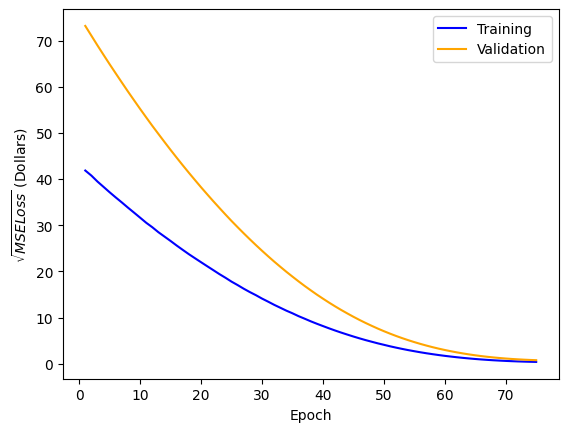

Root MSE Final Validation Loss: 0.62
Validation Directional Accuracy: 50.55%


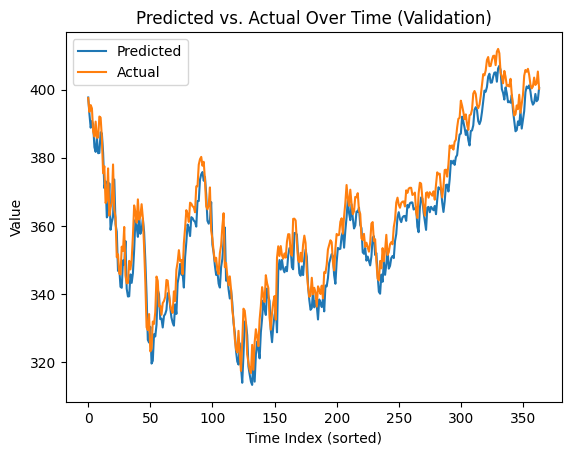

In [28]:
class LinearOneItemForecaster(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x.squeeze(1)
        return x

model = LinearOneItemForecaster()

validate_model(model, processor1, epochs=75)

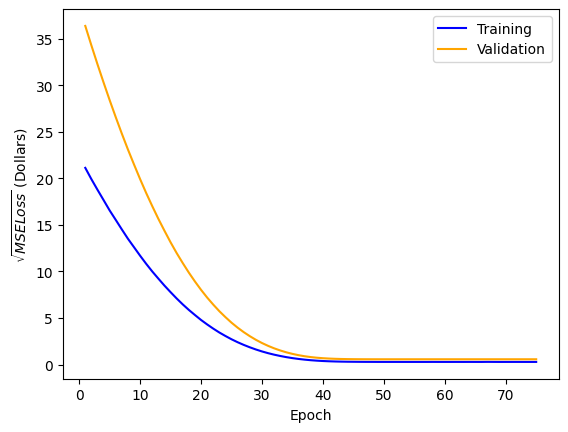

Root MSE Final Validation Loss: 0.33
Validation Directional Accuracy: 49.73%


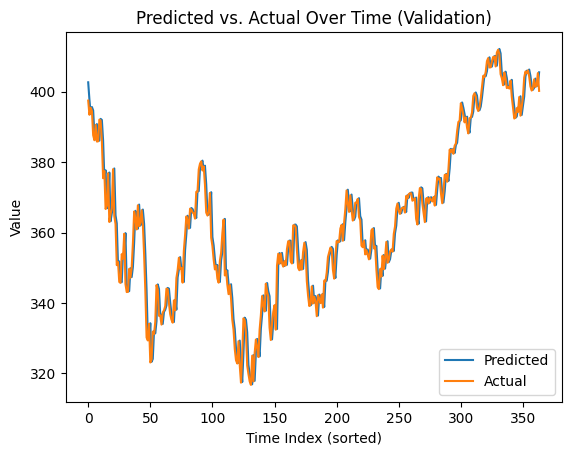

In [29]:
class NoBiasLinearForecaster(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=False)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x.squeeze(1)
        return x

model = NoBiasLinearForecaster()

validate_model(model, processor1, epochs=75)

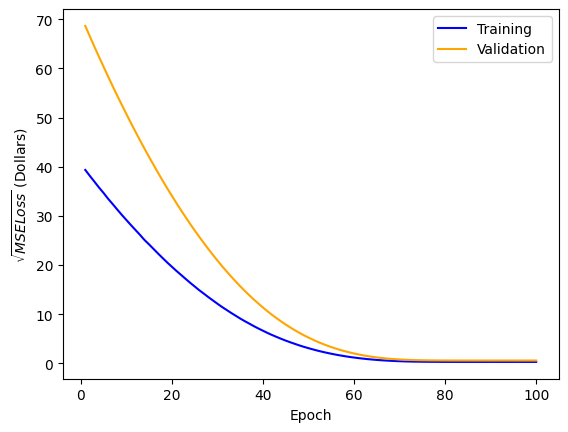

Root MSE Final Validation Loss: 0.33
Validation Directional Accuracy: 50.55%


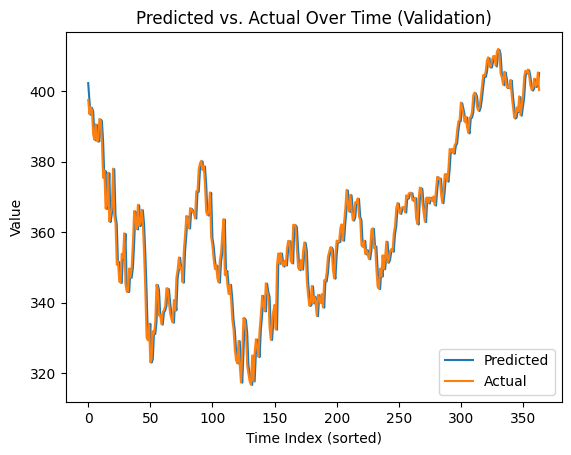

In [33]:
model = LinearOneItemForecaster()

validate_model(model, processor1, epochs=100, weight_decay=0.01)

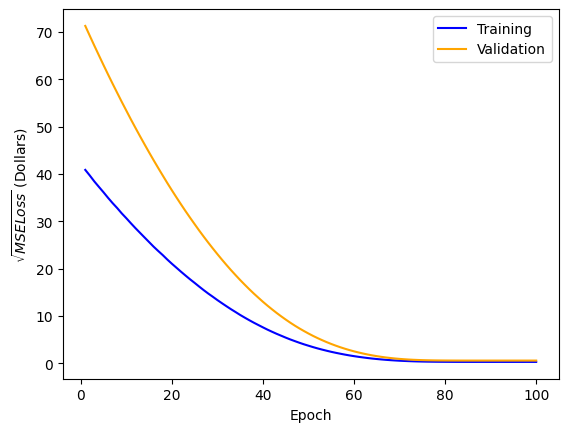

Root MSE Final Validation Loss: 0.33
Validation Directional Accuracy: 49.73%


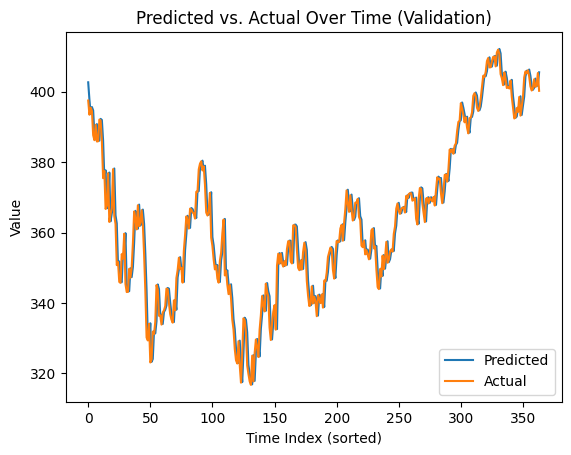

In [35]:
model = NoBiasLinearForecaster()

validate_model(model, processor1, epochs=100, weight_decay=0.01)

[*********************100%***********************]  1 of 1 completed


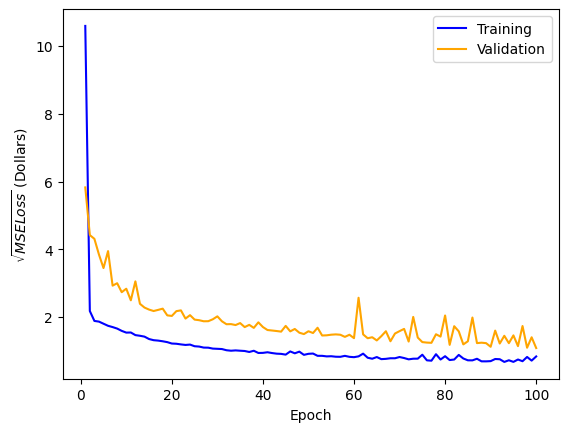

Root MSE Final Validation Loss: 1.18
Validation Directional Accuracy: 51.78%


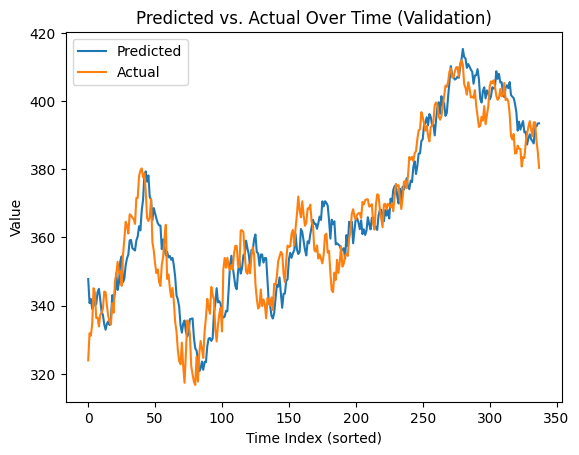

In [36]:
lookback256 = 256

class LinearForecaster(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.linear = nn.Linear(lookback, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.linear(x)
        x = x.squeeze(1)
        return x

model = LinearForecaster(lookback256)

processor256 = ClosePricesPreprocessor(lookback=lookback256)
train_loader, val_loader, test_loader = processor1.get_loaders()

validate_model(model, processor256, epochs=100, weight_decay=0.01)

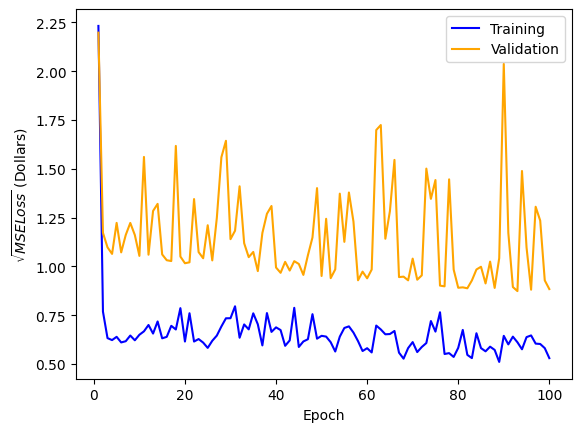

Root MSE Final Validation Loss: 0.78
Validation Directional Accuracy: 52.07%


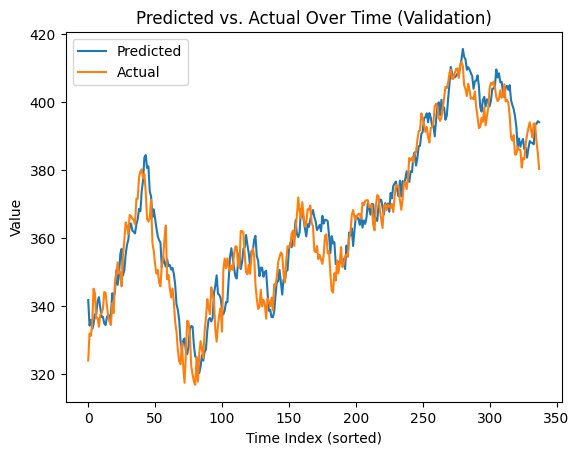

In [37]:
validate_model(model, processor256, epochs=100, weight_decay=0.1)

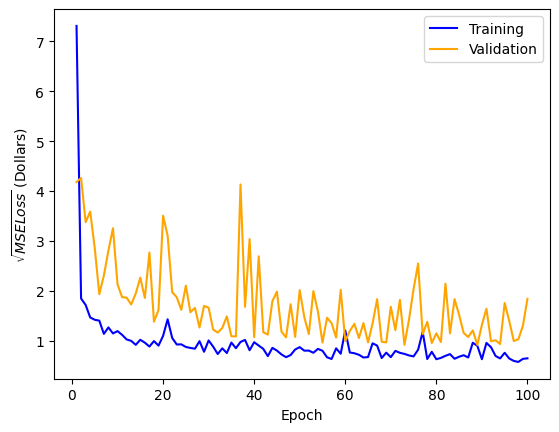

Root MSE Final Validation Loss: 3.38
Validation Directional Accuracy: 50.30%


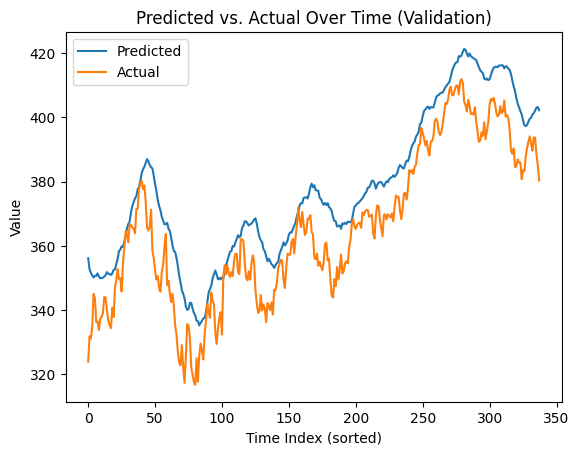

In [38]:
class FullyConnectedForecaster(torch.nn.Module):
    def __init__(self, lookback):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, lookback*2)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(lookback*2, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = x.squeeze(1)
        return x

model = FullyConnectedForecaster(lookback256)

validate_model(model, processor256, epochs=100, weight_decay=0.01)

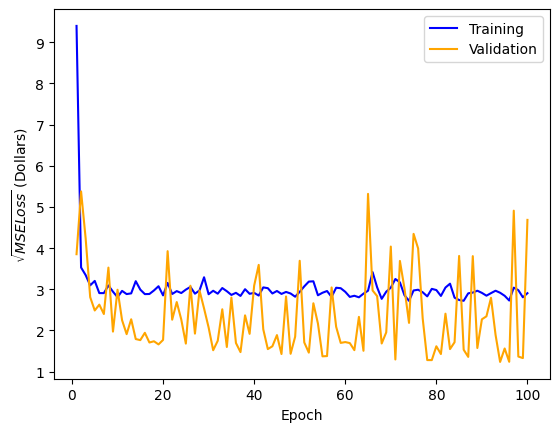

Root MSE Final Validation Loss: 21.96
Validation Directional Accuracy: 50.00%


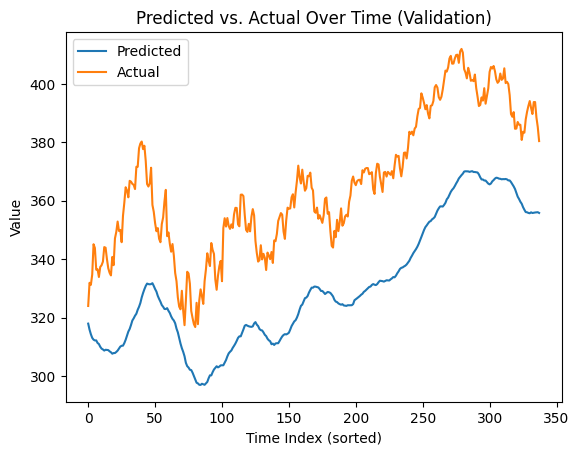

In [39]:
class RegularizedDenseForecaster(torch.nn.Module):
    def __init__(self, lookback, dropout=0.5):
        super().__init__()
        self.layer_1 = nn.Linear(lookback, lookback*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.layer_2 = nn.Linear(lookback*2, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_2(x)
        x = x.squeeze(1)
        return x

model = RegularizedDenseForecaster(lookback256)

validate_model(model, processor256, epochs=100, weight_decay=0.01)

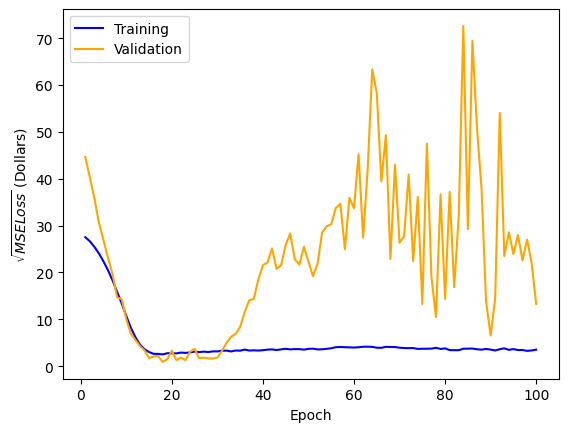

Root MSE Final Validation Loss: 176.23
Validation Directional Accuracy: 47.34%


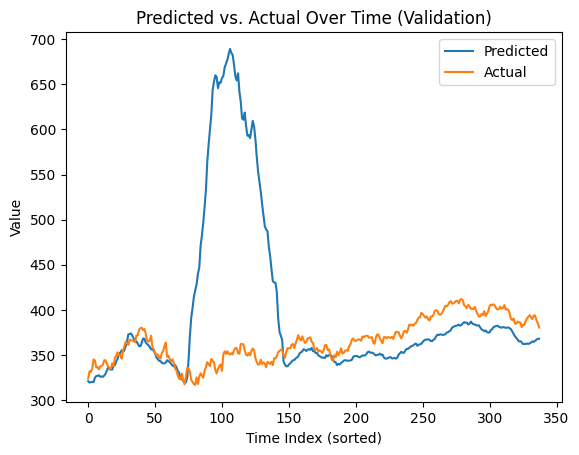

In [40]:
class NormalizedDenseForecaster(torch.nn.Module):
    def __init__(self, lookback, dropout=0.5):
        super().__init__()
        self.batch_norm1 = nn.BatchNorm1d(lookback)
        self.layer_1 = nn.Linear(lookback, lookback*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.batch_norm2 = nn.BatchNorm1d(lookback*2)
        self.layer_2 = nn.Linear(lookback*2, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.batch_norm1(x)
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.batch_norm2(x)
        x = self.layer_2(x)
        x = x.squeeze(1)
        return x

model = NormalizedDenseForecaster(lookback256)

validate_model(model, processor256, epochs=100, weight_decay=0.01)

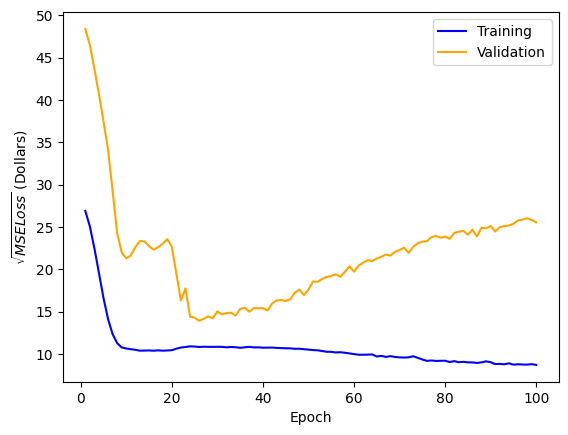

Root MSE Final Validation Loss: 653.08
Validation Directional Accuracy: 50.00%


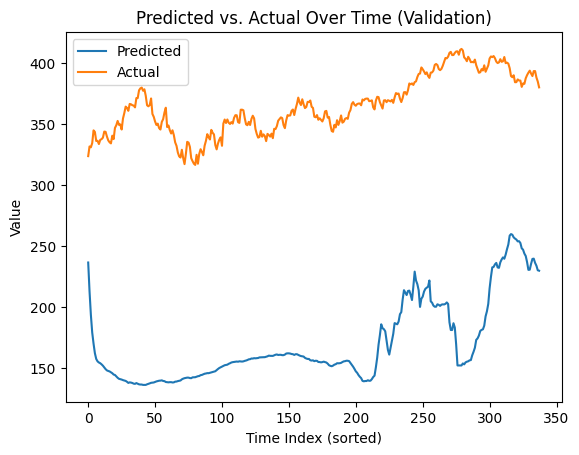

In [41]:
class LayerNormedDenseForecaster(torch.nn.Module):
    def __init__(self, lookback, dropout=0.5):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(lookback)
        self.layer_1 = nn.Linear(lookback, lookback*2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm2 = nn.LayerNorm(lookback*2)
        self.layer_2 = nn.Linear(lookback*2, 1)

    def forward(self, x):
        x = x.squeeze(2)
        x = self.layer_norm1(x)
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer_norm2(x)
        x = self.layer_2(x)
        x = x.squeeze(1)
        return x

model = LayerNormedDenseForecaster(lookback256)

validate_model(model, processor256, epochs=100, weight_decay=0.01)